In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np; np.set_printoptions(linewidth=200, suppress=True)
from copy import deepcopy
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.io import loadmat

In [3]:
import torch; torch.set_printoptions(sci_mode=None)
# Check if CUDA is available
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    compute_device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [4]:
from agm_te.dataset import DataSet
from agm_te.estimate import train_agms, init_agms_from_loaders, _train_agm, plot_agm_output, _TE_from_losses

### Set up synthetic network

In [2]:
from te_datasim.neural import NeuralSimulator

In [5]:
mat = loadmat("synthetic_connectivity.mat")
A = np.array(mat['net'][0])
for i in range(A.shape[0]):
    A[i, i] = 0
A = np.round(A, 2)

constren_1 = 0.9
constren_2 = 0.75

A[2, 7] = constren_1 + 0.1
A[1, 5] = constren_1 + 0.1

A[2, 12] = 0
A[2, 11] = 0
A[0, 13] = constren_1
A[4, 10] = 0
A[4, 11] = constren_1


A[8, 13] = 0
A[9, 13] = constren_2
A[7, 12] = 0
A[8, 10] = constren_2

print(A)
A_extracon = deepcopy(A)

[[0.   0.36 0.   0.   0.29 0.   0.   0.   0.   0.   0.   0.   0.   0.9  0.  ]
 [0.   0.   0.23 0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.41 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.43 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.9  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.52 0.   0.   0.42 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.52 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.4  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.43 0.75 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.38 0.   0.   0.39]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.47 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

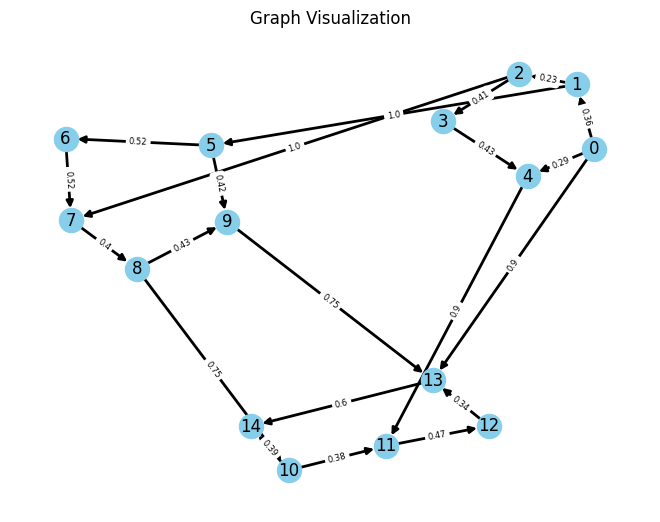

In [6]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
A_mod = deepcopy(A)
for i in range(A_mod.shape[0]):
    for j in range(A_mod.shape[1]):
        if A_mod[i, j] > 0.61:
            A_mod[i, j] = A_mod[i, j]*1.5

G_mod = nx.from_numpy_array(A_mod, create_using=nx.DiGraph)

# Draw the graph
pos = nx.kamada_kawai_layout(G_mod)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', width=2.0, edge_cmap=plt.cm.Blues)

# Draw edge labels to show weights
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.title('Graph Visualization')
plt.show()


### Generate Data

mean of neural activity per channel: [0.32 0.47 0.44 0.5  0.62 0.47 0.25 0.57 0.23 0.3  0.17 0.62 0.29 0.61 0.43]
mean spike count per channel: [0.55 0.86 0.71 0.88 1.39 0.82 0.32 1.07 0.28 0.38 0.24 1.28 0.35 1.28 0.61]
std of spike count per channel: [0.85 1.08 0.98 1.19 1.71 1.06 0.58 1.4  0.53 0.63 0.5  1.62 0.61 1.61 0.86]
mean spike count: 0.73
spike count std: 1.02


Text(0.5, 1.0, 'Input Signals')

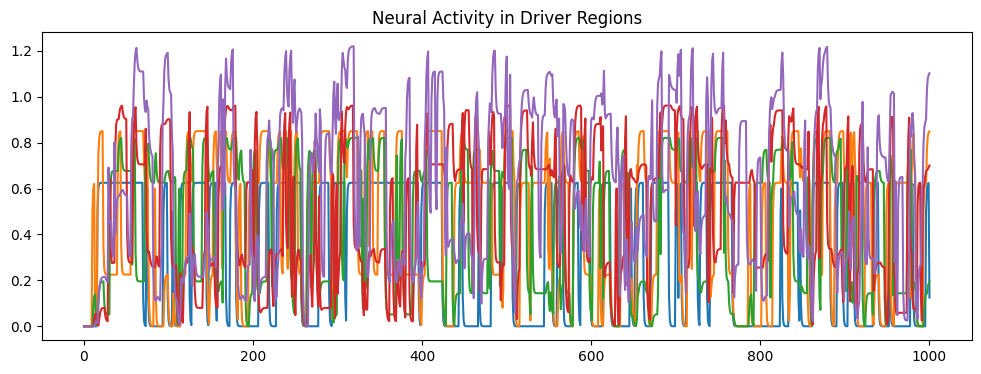

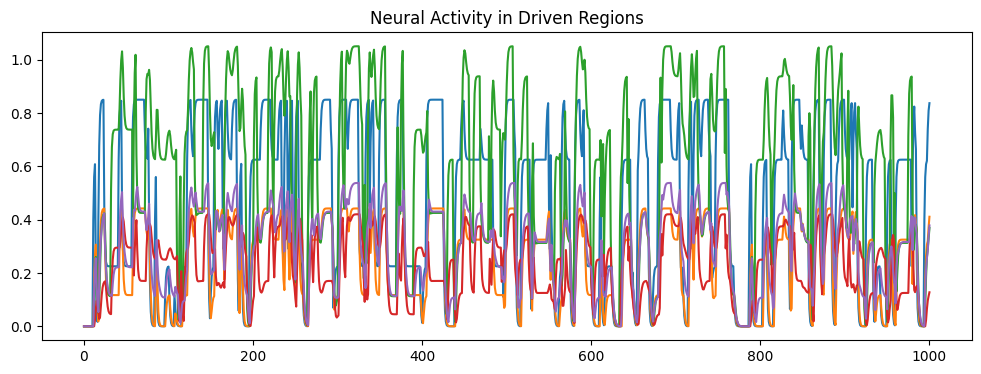

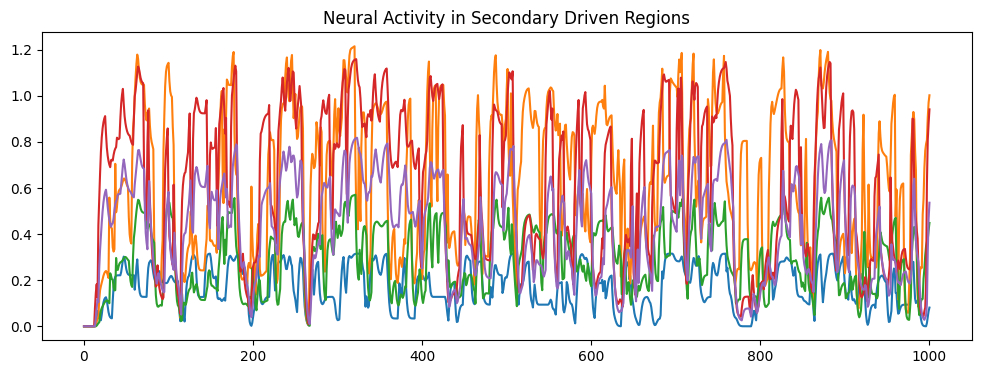

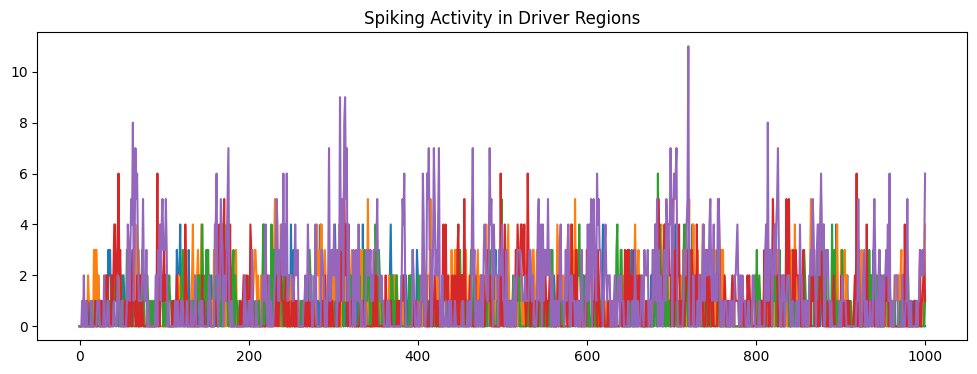

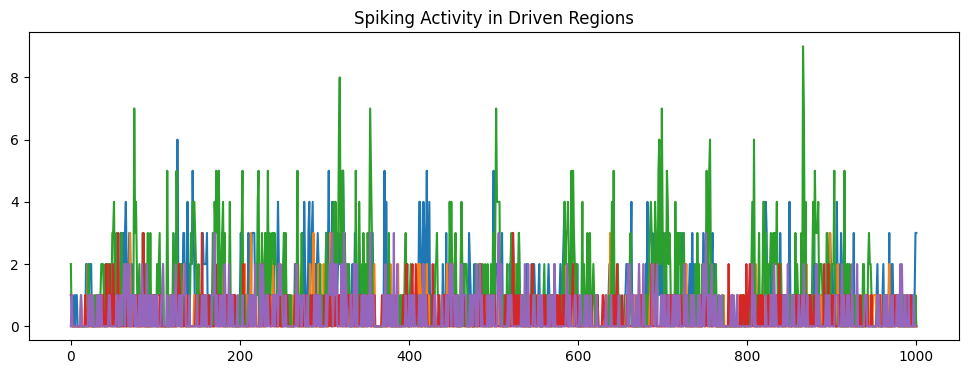

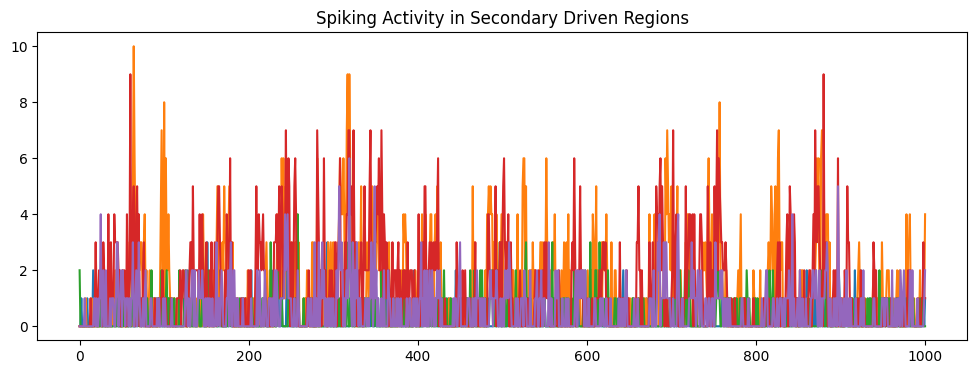

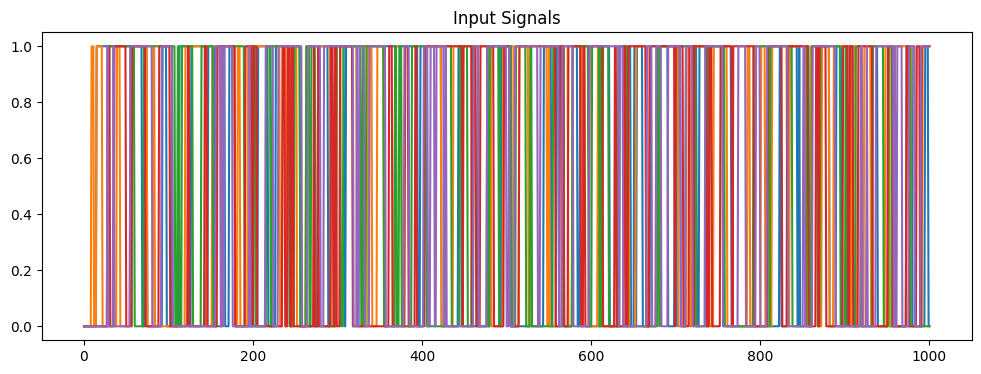

In [7]:
A = A_extracon.T
for i in range(A.shape[0]):
    A[i, i] = -1.0

C = np.zeros_like(A)
for i in range(5):
    C[i, i] = 5

r = np.ones(A.shape[0]) * 100
b = np.zeros(A.shape[0]) - 4.3

generator = NeuralSimulator(A, C, r, b, samplerate=10, mean_duration_down=1.0, mean_duration_up=1.0, sigma=8)

input_signals, neural_activity, bold_signal, spike_counts = generator.simulate(100, 1)

print('mean of neural activity per channel:', np.round(neural_activity.mean(axis=0),2))

print('mean spike count per channel:', np.round(spike_counts.mean(axis=0),2))
print('std of spike count per channel:', np.round(spike_counts.std(axis=0),2))
print('mean spike count:', np.round(np.mean(spike_counts.mean(axis=0)),2))
print('spike count std:', np.round(np.mean(spike_counts.std(axis=0)),2))

plt.figure(figsize=(12, 4))
plt.plot(neural_activity[:,:5], label="Neural Activity")
plt.title("Neural Activity in Driver Regions")

plt.figure(figsize=(12, 4))
plt.plot(neural_activity[:,5:10])
plt.title("Neural Activity in Driven Regions")

plt.figure(figsize=(12, 4))
plt.plot(neural_activity[:,10:])
plt.title("Neural Activity in Secondary Driven Regions")

plt.figure(figsize=(12, 4))
plt.plot(spike_counts[:,:5], label="Neural Activity")
plt.title("Spiking Activity in Driver Regions")

plt.figure(figsize=(12, 4))
plt.plot(spike_counts[:,5:10])
plt.title("Spiking Activity in Driven Regions")

plt.figure(figsize=(12, 4))
plt.plot(spike_counts[:,10:])
plt.title("Spiking Activity in Secondary Driven Regions")

plt.figure(figsize=(12, 4))
plt.plot(input_signals[:,:5])
plt.title("Input Signals")

### Estimate Effective Connectivity using Transfer Entropy

In [8]:
EPOCHS = 2000
HIDDEN_SIZE = 5
BATCH_SIZE = 16

In [9]:
def agmte_cte(dataset_instance, var_from, var_to):
    dataloader_1, dataloader_2 = dataset_instance.get_CTE_dataloaders(var_from=var_from, var_to=var_to, var_cond='remaining')
    model_1, model_2 = init_agms_from_loaders(dataloader_1, dataloader_2, hidden_size=HIDDEN_SIZE, dyn_model_type='GRU', obs_model_type='poisson', timestep=0.1)
    model_1 = model_1.to(compute_device)
    model_2 = model_2.to(compute_device)
    model_1, loss_1, model_2, loss_2= train_agms(model_1, dataloader_1, model_2, dataloader_2, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=0.001, optimize='adam', plot_loss=False)
    te = _TE_from_losses(loss_1, loss_2)
    return np.round(np.clip(te, 0, None), 2)

def agmte_te(dataset_instance, var_from, var_to):
    dataloader_1, dataloader_2 = dataset_instance.get_TE_dataloaders(var_from=var_from, var_to=var_to)
    model_1, model_2 = init_agms_from_loaders(dataloader_1, dataloader_2, hidden_size=HIDDEN_SIZE, dyn_model_type='GRU', obs_model_type='poisson', timestep=0.1)
    model_1 = model_1.to(compute_device)
    model_2 = model_2.to(compute_device)
    model_1, loss_1, model_2, loss_2 = train_agms(model_1, dataloader_1, model_2, dataloader_2, batch_size=BATCH_SIZE, epochs=EPOCHS, learning_rate=0.001, optimize='adam', plot_loss=False)
    te = _TE_from_losses(loss_1, loss_2)

    return np.round(te, 2)

In [13]:
CTE_matrix_list = []

for r in range(8):
    print("\n<<< Replicate", r, ">>>")

    # generate data
    data_dict = {}
    data_dict["driver"] = []
    data_dict["driven1"] = []
    data_dict["driven2"] = []

    for i in range(BATCH_SIZE):
        input_signals, neural_activity, bold_signal, spike_counts = generator.simulate(100, i+r*32)

        data_dict["driver"].append(spike_counts[:,:5])
        data_dict["driven1"].append(spike_counts[:,5:10])
        data_dict["driven2"].append(spike_counts[:,10:])

    dataset = DataSet(data_dict)

    # calculate TE
    TE_driver_driven1  = agmte_te(dataset, var_from='driver', var_to='driven1')
    TE_driven1_driver  = agmte_te(dataset, var_from='driven1', var_to='driver')
    TE_driver_driven2  = agmte_te(dataset, var_from='driver', var_to='driven2')
    TE_driven2_driver  = agmte_te(dataset, var_from='driven2', var_to='driver')
    TE_driven1_driven2 = agmte_te(dataset, var_from='driven1', var_to='driven2')
    TE_driven2_driven1 = agmte_te(dataset, var_from='driven2', var_to='driven1')

    CTE_matrix = np.array([ [0, TE_driver_driven1, TE_driver_driven2],
                            [TE_driven1_driver, 0, TE_driven1_driven2],
                            [TE_driven2_driver, TE_driven2_driven1, 0]])

    CTE_matrix_list.append(CTE_matrix)

CTE_matrix_avg = np.round(np.mean(CTE_matrix_list, axis=0), 4)
print()
print(CTE_matrix_avg.T)


<<< Replicate 0 >>>
Epoch [1990/2000], Loss: 2.75281055
<<< Replicate 1 >>>
Epoch [1990/2000], Loss: 2.72609942
<<< Replicate 2 >>>
Epoch [1990/2000], Loss: 2.72171834
<<< Replicate 3 >>>
Epoch [1990/2000], Loss: 2.66932418
<<< Replicate 4 >>>
Epoch [1990/2000], Loss: 2.69990561
<<< Replicate 5 >>>
Epoch [1990/2000], Loss: 2.67084258
<<< Replicate 6 >>>
Epoch [1990/2000], Loss: 2.73631847
<<< Replicate 7 >>>
Epoch [1990/2000], Loss: 2.73291876
[[0.     0.0388 0.0088]
 [0.13   0.     0.0137]
 [0.1675 0.0275 0.    ]]


### Estimate Effective Connectivity using Conditional Transfer Entropy

In [14]:
CTE_matrix_list = []

for r in range(8):
    print("\n<<< Replicate", r, ">>>")

    # generate data
    data_dict = {}
    data_dict["driver"] = []
    data_dict["driven1"] = []
    data_dict["driven2"] = []

    for i in range(BATCH_SIZE):
        input_signals, neural_activity, bold_signal, spike_counts = generator.simulate(100, i+r*32)

        data_dict["driver"].append(spike_counts[:,:5])
        data_dict["driven1"].append(spike_counts[:,5:10])
        data_dict["driven2"].append(spike_counts[:,10:])

    dataset = DataSet(data_dict)

    # calculate CTE
    CTE_driver_driven1  = agmte_cte(dataset, var_from='driver', var_to='driven1')
    CTE_driven1_driver  = agmte_cte(dataset, var_from='driven1', var_to='driver')
    CTE_driver_driven2  = agmte_cte(dataset, var_from='driver', var_to='driven2')
    CTE_driven2_driver  = agmte_cte(dataset, var_from='driven2', var_to='driver')
    CTE_driven1_driven2 = agmte_cte(dataset, var_from='driven1', var_to='driven2')
    CTE_driven2_driven1 = agmte_cte(dataset, var_from='driven2', var_to='driven1')

    CTE_matrix = np.array([ [0, CTE_driver_driven1, CTE_driver_driven2],
                            [CTE_driven1_driver, 0, CTE_driven1_driven2],
                            [CTE_driven2_driver, CTE_driven2_driven1, 0]])

    CTE_matrix_list.append(CTE_matrix)

CTE_matrix_avg_2 = np.round(np.mean(CTE_matrix_list, axis=0), 4)
print()
print(CTE_matrix_avg_2.T)


<<< Replicate 0 >>>
Epoch [1990/2000], Loss: 2.61797824
<<< Replicate 1 >>>
Epoch [1990/2000], Loss: 2.57660983
<<< Replicate 2 >>>
Epoch [1990/2000], Loss: 2.61641734
<<< Replicate 3 >>>
Epoch [1990/2000], Loss: 2.59283011
<<< Replicate 4 >>>
Epoch [1990/2000], Loss: 2.59113613
<<< Replicate 5 >>>
Epoch [1990/2000], Loss: 2.53722534
<<< Replicate 6 >>>
Epoch [1990/2000], Loss: 2.58576126
<<< Replicate 7 >>>
Epoch [1990/2000], Loss: 2.60943939
[[0.     0.0088 0.0275]
 [0.1212 0.     0.005 ]
 [0.1538 0.0088 0.    ]]
